<a href="https://colab.research.google.com/github/joaosMart/fish-species-class-siglip/blob/main/Fish_detection_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's load the necessary librarires.

In [1]:
!pip install transformers open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import glob
import cv2
import pandas as pd
import pickle
from tqdm.notebook import tqdm
from PIL import Image
import torch
import torch.nn.functional as F
import open_clip

Mounted at /content/drive


This is my test dataset. It was created by selecting randomly 400 frames from different videos and labeling them by hand with the thought of getting a somewhat even distribution. After this the bad frames were selected and removed. Bad frames were frames where the fish doesn't appear fully in the image. It was decided to remove this because they are not really included in the species classification process.

> 167 images with fish ||| 163 images with no fish

In [3]:
positive_images = glob.glob("/content/drive/My Drive/Summer 2023 - fish ML/validation_set/fish/*.jpg")
negative_images = glob.glob("/content/drive/My Drive/Summer 2023 - fish ML/validation_set/no_fish/*.jpg")

In [4]:
len(positive_images)

168

# Comparing Models

In [5]:
import open_clip

results = {}
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Below I iterate through all the data once for each model and save the infered probabilities for each image.

In [6]:
import torch
import torch.nn.functional as F
from PIL import Image
import open_clip
from tqdm.auto import tqdm

# Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model names and checkpoints
hf_model_names = [
    ['ViT-B-16-SigLIP', 'webli'],
    ['ViT-SO400M-14-SigLIP-384', 'webli'],
    ['ViT-B-16-SigLIP-384', 'webli'],
    ['ViT-SO400M-14-SigLIP', 'webli'],
    ['ViT-B-16-SigLIP-512', 'webli'],
    ['ViT-B-32', 'laion2b_s34b_b79k'],
    ['ViT-L-14', 'laion2b_s32b_b82k'],
    ['ViT-H-14', 'laion2b_s32b_b79k'],
    ['EVA02-L-14-336', 'merged2b_s6b_b61k']
]

results = {}

# Preprocess text inputs
text_inputs = ["A salmon-like fish swimming", "A container in a river with nothing in it."]

# Use a context manager to automatically handle GPU memory
with torch.cuda.device(0):
    for hf_model, pretraining_checkpoint in tqdm(hf_model_names, desc="Processing models"):
        if hf_model in results:
            continue

        # Load model and preprocess
        model, _, preprocess_val = open_clip.create_model_and_transforms(hf_model, pretrained=pretraining_checkpoint)
        model = model.to(device)
        tokenizer = open_clip.get_tokenizer(hf_model)

        # Tokenize and encode text
        text = tokenizer(text_inputs, context_length=model.context_length).to(device)

        with torch.no_grad(), torch.cuda.amp.autocast():
            text_features = F.normalize(model.encode_text(text), dim=-1)

        results[hf_model] = []

        # Process images in batches
        batch_size = 32
        for image_class, image_list in [(1, positive_images), (0, negative_images)]:
            for i in tqdm(range(0, len(image_list), batch_size)):
                batch = image_list[i:i+batch_size]
                images = torch.stack([preprocess_val(Image.open(img_path)).to(device) for img_path in batch])

                with torch.no_grad(), torch.cuda.amp.autocast():
                    image_features = F.normalize(model.encode_image(images), dim=-1)
                    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

                results[hf_model].extend([[image_class, prob.cpu()] for prob in text_probs])

        # Clear CUDA cache
        torch.cuda.empty_cache()

# Process results as needed

Processing models:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

/tmp/ipython-input-1093434565.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipython-input-1093434565.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


  0%|          | 0/6 [00:00<?, ?it/s]

open_clip_model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

open_clip_model.safetensors:   0%|          | 0.00/814M [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

open_clip_model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

open_clip_model.safetensors:   0%|          | 0.00/815M [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

open_clip_pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

open_clip_model.safetensors:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

open_clip_model.safetensors:   0%|          | 0.00/856M [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

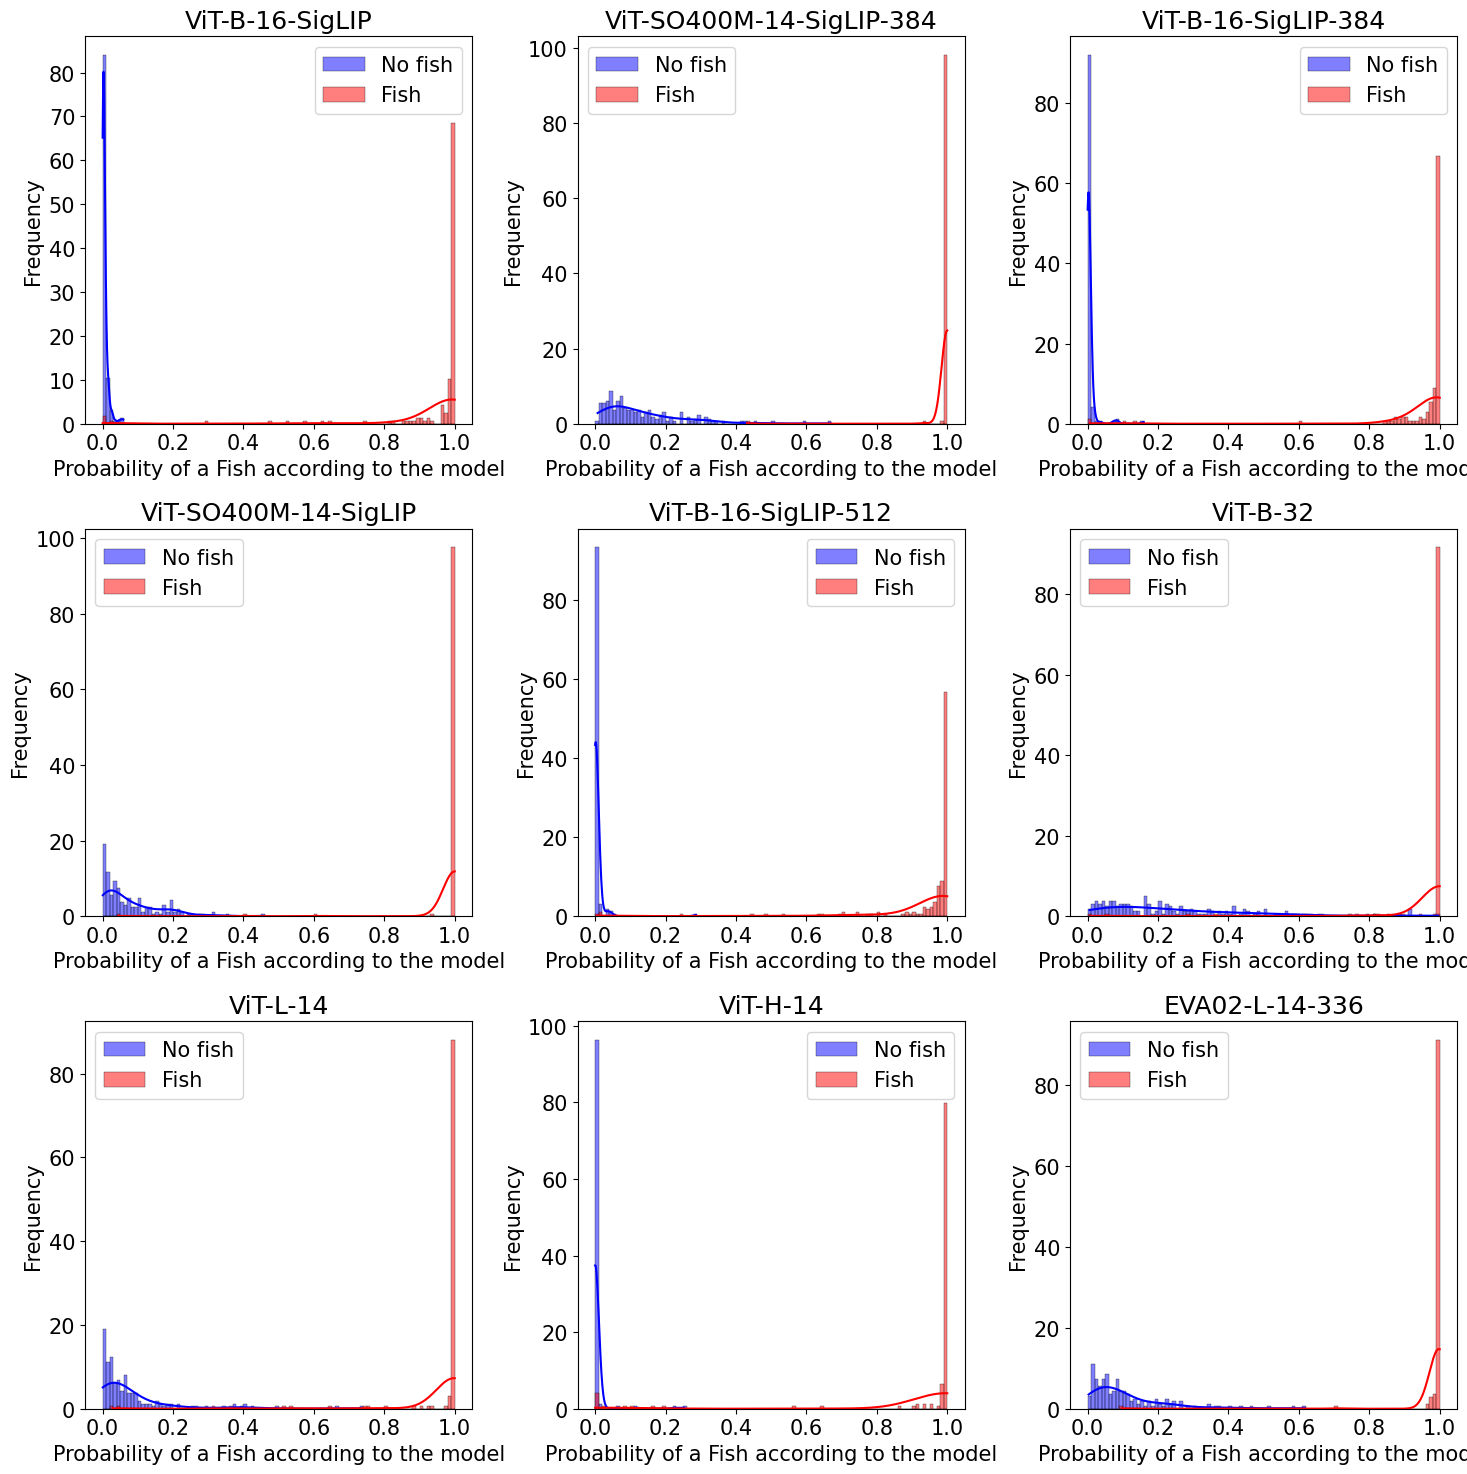

In [7]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 15})

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten() # Flatten the 3x3 matrix to easily index it

for idx, hf_model in enumerate(hf_model_names):
    # Access the corresponding subplot
    ax = axs[idx]


    # Separate b_i values based on their corresponding class a_i
    b_values_class_0 = [probabilities.tolist()[0] for class_label, probabilities in results[hf_model[0]] if class_label == 0]
    b_values_class_1 = [probabilities.tolist()[0] for class_label, probabilities in results[hf_model[0]] if class_label == 1]

    # Plotting
    sns.histplot(b_values_class_0, bins=[x/100 for x in range(101)], color='blue', kde=True, label='No fish', stat="density", ax=ax)
    sns.histplot(b_values_class_1, bins=[x/100 for x in range(101)], color='red', kde=True, label='Fish', stat="density", ax=ax)

    ax.set_xlabel('Probability of a Fish according to the model')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.set_title(hf_model[0])

# Adjust layout so that titles and axes don't overlap
plt.tight_layout()

# Save the entire figure
plt.savefig("Comparing_distributions_grid.png", dpi=300)

# Show the plot
plt.show()

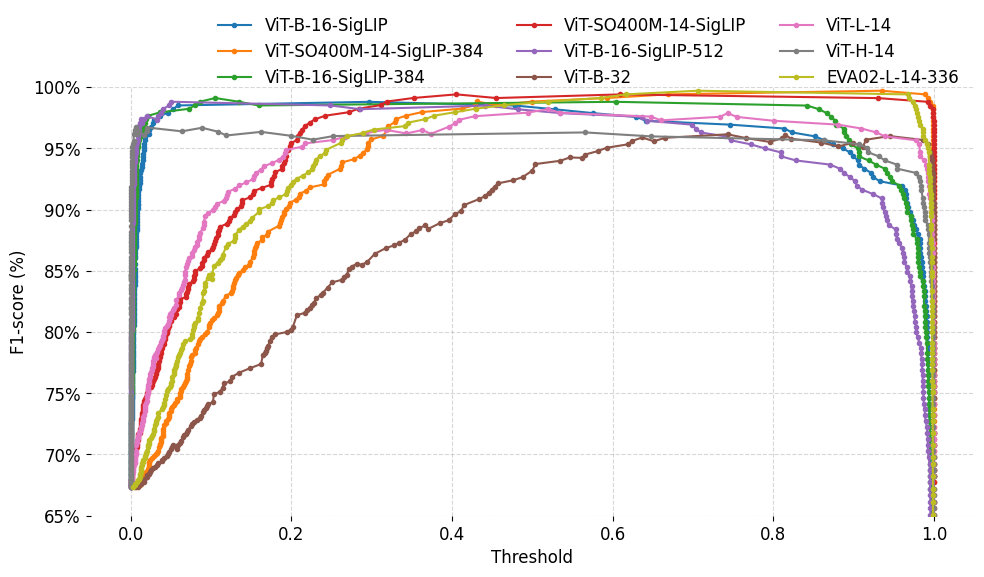

'./model_performance_data.csv'

In [9]:
# Compute the AUC and print a ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
from matplotlib.ticker import FuncFormatter

plt.rcParams.update({'font.size': 12})

def to_percentage(x, pos):
    return f'{int(x)}%'  # Convert to integer and add percentage sign

plt.figure(figsize=(10, 6))
data_to_save = []  # List to hold data for saving
for model, _ in hf_model_names:
    # Extract true class labels and predicted probabilities
    true_classes = [item[0] for item in results[model]]
    predicted_probabilities = [item[1].tolist()[0] for item in results[model]]

    # Convert to numpy arrays
    # true_classes = np.array(true_classes)
    # predicted_probabilities = np.array(predicted_probabilities)

    # Compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(true_classes, predicted_probabilities)

    # Append an additional threshold at the end to make lengths equal
    thresholds = np.append(thresholds, 1)

    # Compute F1 scores and convert to percentage
    f1_scores = 2 * (precision * recall) / (precision + recall) * 100  # Multiply by 100 for percentage
    f1_scores = np.nan_to_num(f1_scores)

    plt.plot(thresholds, f1_scores, label=model, marker='.')

    # Save the data for this model
    model_data = pd.DataFrame({
        'Threshold': thresholds,
        'F1-Score': f1_scores
    })
    model_data['Model'] = model
    data_to_save.append(model_data)

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage))
plt.xlabel('Threshold')
plt.ylabel('F1-score (%)')  # Updated label for percentage
plt.ylim(65, 100)  # Adjusted for percentage
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.20), ncol=3, frameon=False)
plt.grid(True, linestyle='--', alpha=0.5)

# Removing the frame from the plot
for spine in plt.gca().spines.values():
    spine.set_visible(False)


plt.tight_layout()
plt.savefig("f1_score_model_comparison.png", dpi=300)
plt.show()

# # Combine all model data into a single DataFrame
all_data = pd.concat(data_to_save)

# Save to a CSV file
file_path = './model_performance_data.csv'
all_data.to_csv(file_path, index=False)

file_path

The best models are the folllowing:

- 'ViT-B-16-SigLIP-384', 'webli'
- 'ViT-SO400M-14-SigLIP', 'webli'
- 'EVA02-L-14-336', 'merged2b_s6b_b61k'

Below there is a table that shows the number of parameters of the best models and their F1-score.

Markdown | Params | F1-score
--- | --- | ---
`ViT-B-16-SigLIP-384` | 203.45 | 0.99
`ViT-SO400M-14-SigLIP` | 877.36 | 0.99
`EVA02-L-14-336 ` | 428.08 | 1.00

Considering how similar the F1-scores are (almost perfect) and the number of params on each model the decision on the final model

The decision on the final model to use will tak into consideration how computationally expensive the model is and the F1 score calculated. After some consideration and given how small the difference is between the F1-score the final model chosen will be the one with the less amount of parameters, i.e. the model `ViT-B-16-SigLIP-384`.


# Prompt Engineering

positive_prompts = [
    "Salmon-like fish swimming",
    "An underwater photo of a salmon-like fish seen clearly swimming.",
    "Image of salmon-like fish in a contained environment.",
    "A photo of a salmon-like fish in a controlled river environment.",
    "Image of fish swimming in a confined water space.",
    "Clear image of fish swimming in a river.",
    "Image of at least one salmon-like fish in a contained environment."
]

No fish prompts:
- "A container in a river with nothing in it."
- "Transparent water container in a river, without any fish."
- "A confined water space without marine life in it."
- "Controlled river environment free from fish."
- "A contained environment with nothing in it."
- "A confined water space with nothing in it."

In [10]:
import torch
import torch.nn.functional as F
import open_clip
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

model_name = "ViT-SO400M-14-SigLIP"


# Load model and tokenizer
model, _, preprocess_val = open_clip.create_model_and_transforms(model_name, pretrained="webli")
tokenizer = open_clip.get_tokenizer(model_name)

# Define prompts
positive_prompts = [
    "Salmon-like fish swimming",
    "An underwater photo of a salmon-like fish seen clearly swimming.",
    "Image of salmon-like fish in a contained environment.",
    "A photo of a salmon-like fish in a controlled river environment.",
    "Image of fish swimming in a confined water space.",
    "Clear image of fish swimming in a river.",
    "Image of at least one salmon-like fish in a contained environment."
]

negative_prompts = [
    "A container in a river with nothing in it.",
    "An image of an empty white water container.",
    "An underwater photo of a confined water space with nothing in it.",
    "A photo of a confined water space with nothing in it.",
    "A photo of an empty confined white water space.",
    "An image of a controlled environment with nothing in it.",
    "Controlled river environment free from fish.",
    "A contained environment with nothing in it.",
    "An image of a empty container with nothing in it."
]

In [11]:
chosen_fish_prompts = [
    "Salmon-like fish swimming",
    "An underwater photo of a salmon-like fish seen clearly swimming.",
    "Image of salmon-like fish in a contained environment.",
    "A photo of a salmon-like fish in a controlled river environment.",
    "Image of at least one salmon-like fish in a contained environment."
]

chosen_no_fish_prompts = [
    "An image of an empty white water container.",
    "A contained environment with nothing in it.",
    "An image of a empty container with nothing in it."
]

In [12]:
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm.auto import tqdm

# Ensure GPU is being used if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Tokenize and encode text positive prompts
p_text = tokenizer(positive_prompts, context_length=model.context_length).to(device)
n_text = tokenizer(negative_prompts, context_length=model.context_length).to(device)

# Ensemble prompts
ensemb_p_text = tokenizer(chosen_fish_prompts, context_length=model.context_length).to(device)
ensemb_n_text = tokenizer(chosen_no_fish_prompts, context_length=model.context_length).to(device)

with torch.no_grad(), torch.cuda.amp.autocast():
    # Prompt Encoding
    p_text_features = model.encode_text(p_text)
    n_text_features = model.encode_text(n_text)
    p_text_features = F.normalize(p_text_features, dim=-1)
    n_text_features = F.normalize(n_text_features, dim=-1)

    # Ensemble Encoding and computing
    ensemb_p_text_features = model.encode_text(ensemb_p_text)
    ensemb_n_text_features = model.encode_text(ensemb_n_text)
    text_features = torch.stack((ensemb_n_text_features.mean(axis = 0),
                                 ensemb_p_text_features.mean(axis = 0)))
    text_features = F.normalize(text_features, dim=-1)



# Initialize a results list to store the scores
results = []

# Batch processing
batch_size = 64  # Adjust based on GPU memory

# Iterate through each class of images (1 for positive, 0 for negative)
for image_class, image_list in [(1, positive_images), (0, negative_images)]:
    for i in range(0, len(image_list), batch_size):
        batch_paths = image_list[i:i+batch_size]

        # Load and preprocess images in batch
        images = torch.stack([preprocess_val(Image.open(img_path)).to(device) for img_path in batch_paths])

        # Compute image features
        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = F.normalize(model.encode_image(images), dim=-1)

            # Compute cosine similarity (no softmax)
            text_probs_positive = (100.0 * image_features @ p_text_features.T)#.softmax(dim=-1)
            text_probs_negative = (100.0 * image_features @ n_text_features.T)#.softmax(dim=-1)
            text_probs = (100.0 * image_features @ text_features.T)
        # Store the results
        for j, img_path in enumerate(batch_paths):
            results.append({
                'image_path': img_path,
                'image_class': image_class,
                'positive_prompts_probabilities': text_probs_positive[j].cpu().numpy(),
                'negative_prompts_probabilities': text_probs_negative[j].cpu().numpy(),
                'embedding_evaluation': text_probs[j].cpu().numpy() # Convert tensor to NumPy array for easier handling
            })

        # Clear CUDA cache to free up memory
        torch.cuda.empty_cache()

    # Show progress
    print(f"Processed {image_class} images")

# Results are now in the 'results' list


/tmp/ipython-input-625426255.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
/tmp/ipython-input-625426255.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Processed 1 images
Processed 0 images


## Results Comparison (Embedding vs. All prompts)

In [ ]:
results

[{'image_path': '/content/drive/MyDrive/Summer 2023 - fish ML/validation_set/test_set_final/fish/laxaleir2021_vid_437.jpg',
  'image_class': 1,
  'positive_prompts_probabilities': array([19.52, 20.58, 20.8 , 18.28], dtype=float16),
  'negative_prompts_probabilities': array([-0.4985,  6.438 ,  1.248 ], dtype=float16),
  'embedding_evaluation': array([ 2.992, 21.4  ], dtype=float16)},
 {'image_path': '/content/drive/MyDrive/Summer 2023 - fish ML/validation_set/test_set_final/fish/laxaleir2020_vid_846.jpg',
  'image_class': 1,
  'positive_prompts_probabilities': array([19.02, 20.17, 20.19, 17.61], dtype=float16),
  'negative_prompts_probabilities': array([-2.395,  6.098,  1.892], dtype=float16),
  'embedding_evaluation': array([ 2.424, 20.81 ], dtype=float16)},
 {'image_path': '/content/drive/MyDrive/Summer 2023 - fish ML/validation_set/test_set_final/fish/krossa2021_vid_1044.jpg',
  'image_class': 1,
  'positive_prompts_probabilities': array([17.1 , 17.67, 19.61, 17.47], dtype=float16),


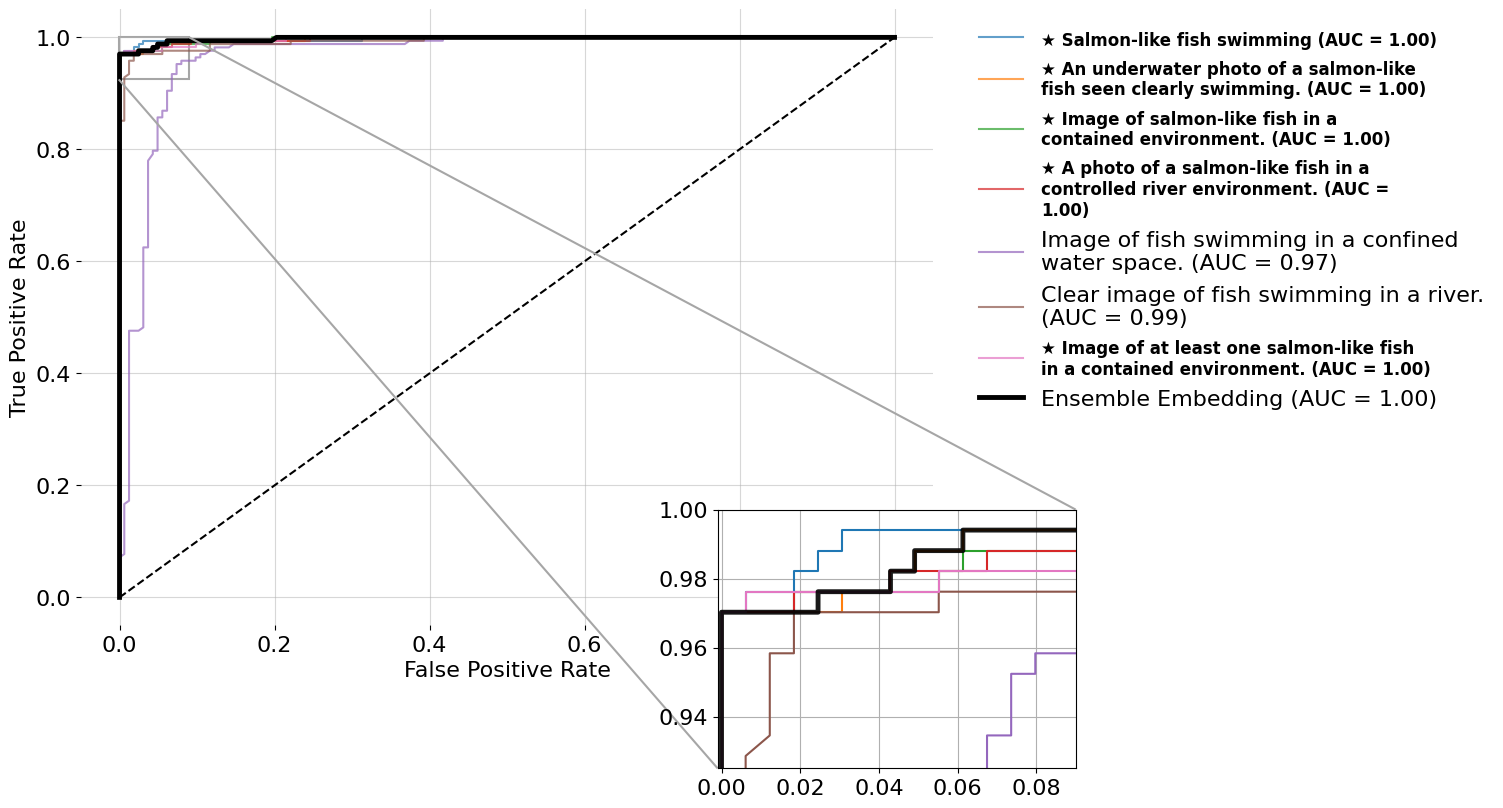

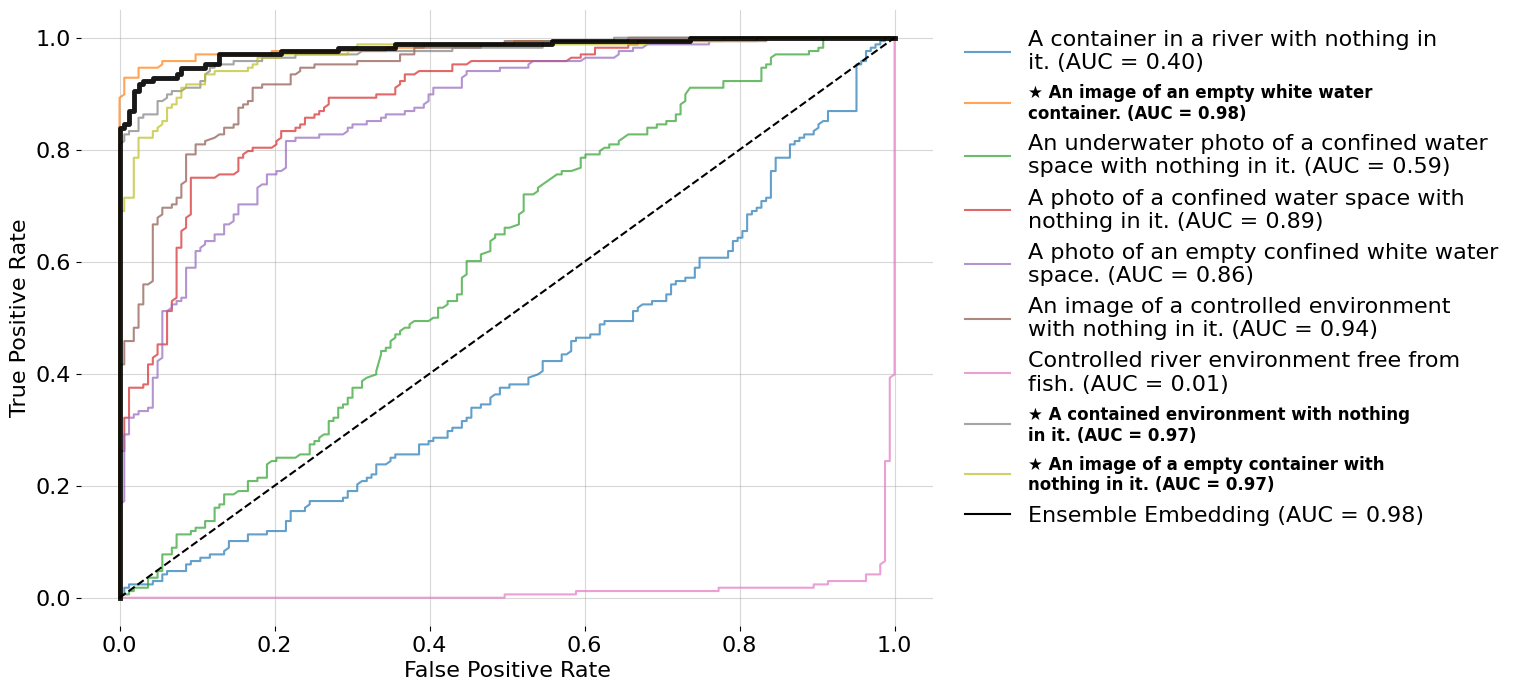

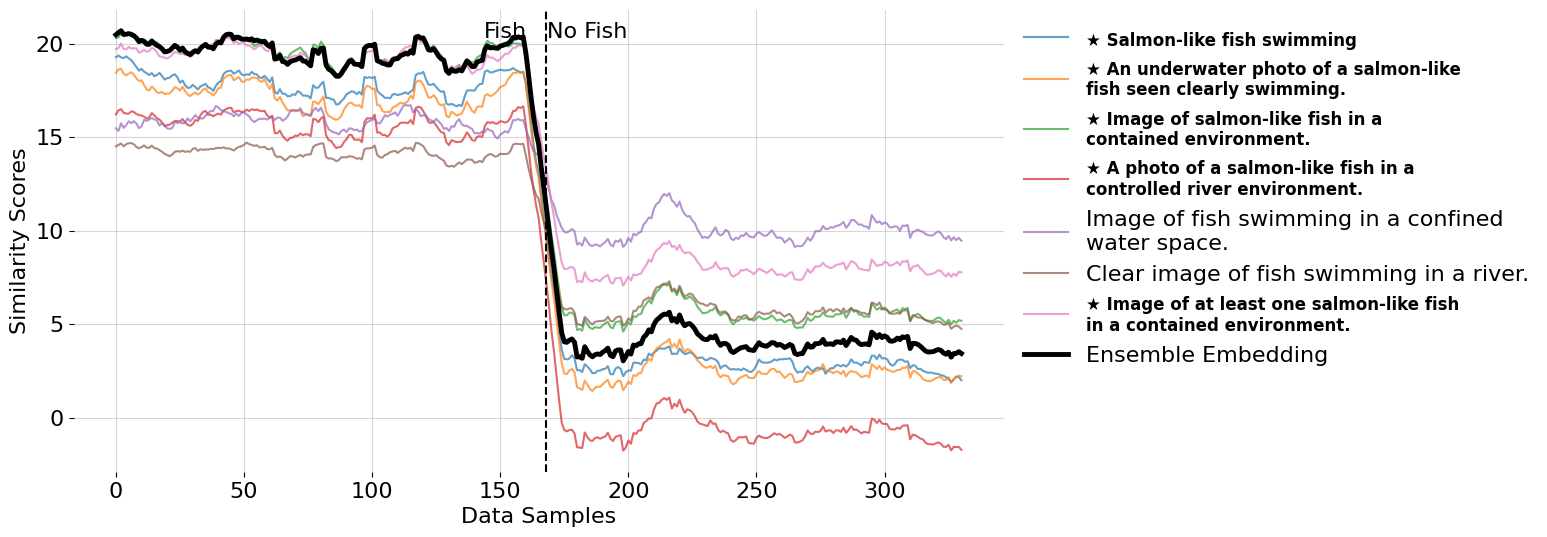

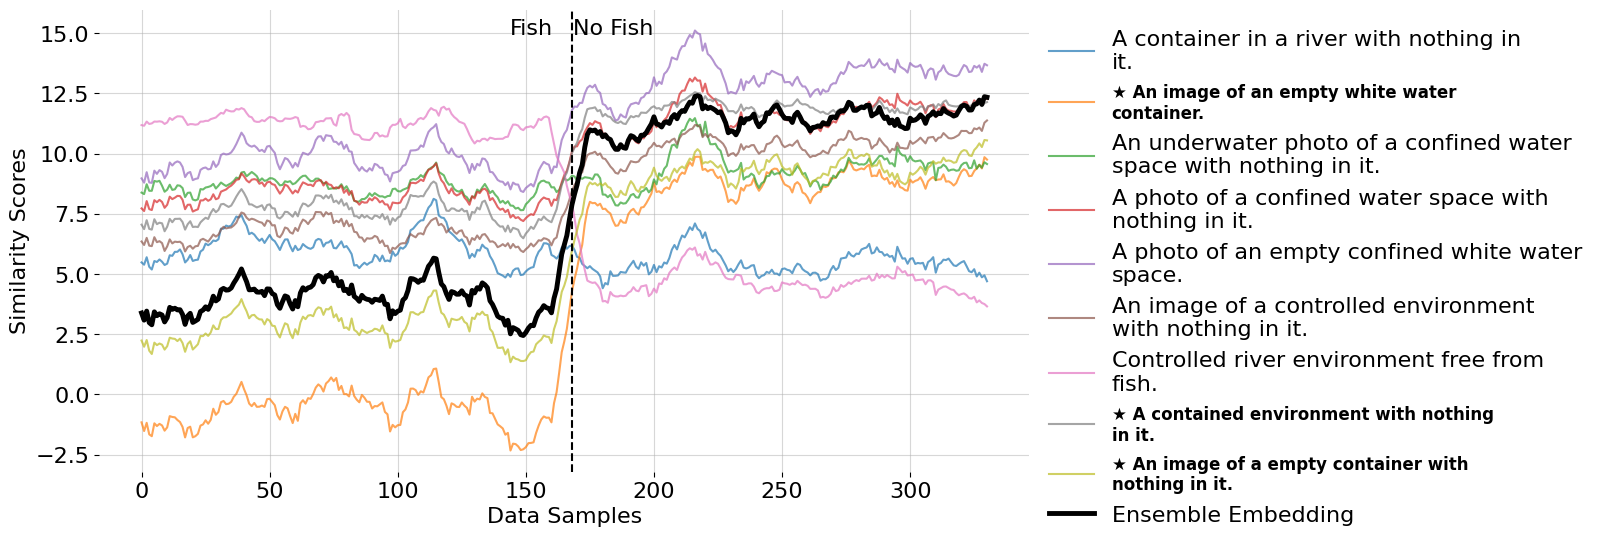

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib.font_manager import FontProperties
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from scipy.ndimage import uniform_filter1d

def softmax(x, axis=-1, apply = True):
    """
    Compute softmax values for each set of scores in x.

    Parameters:
    x (numpy.ndarray): input array
    axis (int): axis along which to compute softmax (default: -1)

    Returns:
    numpy.ndarray: softmax values
    """

    if apply:
      e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
      res = e_x / np.sum(e_x, axis=axis, keepdims=True)
    else:
      res = x
    return res

def wrap_legend_labels(label, max_length=40):
    if len(label) <= max_length:
        return label
    words = label.split()
    lines = []
    current_line = []
    current_length = 0
    for word in words:
        if current_length + len(word) > max_length:
            lines.append(' '.join(current_line))
            current_line = [word]
            current_length = len(word)
        else:
            current_line.append(word)
            current_length += len(word) + 1
    if current_line:
        lines.append(' '.join(current_line))
    return '\n'.join(lines)

# Convert the results to a NumPy array for easier analysis
positive_probabilities = np.array([softmax(result['positive_prompts_probabilities'], axis=-1, apply=False) for result in results])
negative_probabilities = np.array([softmax(result['negative_prompts_probabilities'], axis=-1, apply = False) for result in results])
positive_scores = np.array([result['positive_prompts_probabilities'] for result in results])
negative_scores = np.array([result['negative_prompts_probabilities'] for result in results])
negative_embedding = np.array([result['embedding_evaluation'][0] for result in results])
negative_embedding_probabilities = np.array([softmax(result['embedding_evaluation'],axis = -1, apply = False)[0] for result in results])
positive_embedding = np.array([result['embedding_evaluation'][1] for result in results])
positive_embedding_probabilities = np.array([softmax(result['embedding_evaluation'],axis = -1, apply = False)[1] for result in results])
true_labels = np.array([result['image_class'] for result in results])

# Create font properties for bold text
bold_font = FontProperties(weight='bold')

# Plot 1: ROC Curves for positive prompts
plt.figure(figsize=(11, 8))
plt.rcParams.update({'font.size': 16})

# Adjusting the main plot spines
ax_main = plt.gca()
ax_main.spines['top'].set_visible(False)
ax_main.spines['right'].set_visible(False)
ax_main.spines['bottom'].set_visible(False)
ax_main.spines['left'].set_visible(False)

# Initialize the inset using inset_axes
axins = inset_axes(ax_main, width="70%", height="70%", loc="lower right",
                   bbox_to_anchor=(0.58, -0.25, 0.6, 0.6), bbox_transform=ax_main.transAxes)
axins.grid(True)
axins.set_xlim(-0.001, 0.09) #(-0.001, 0.09)
axins.set_ylim(0.925, 1.000)

# Plotting ROC Curves for positive prompts
lines = []
labels = []
for i, prompt in enumerate(positive_prompts):
    pos_prompt_scores = positive_probabilities[:, i]
    auc = roc_auc_score(true_labels, pos_prompt_scores)
    fpr, tpr, _ = roc_curve(true_labels, pos_prompt_scores)

    # Add star for chosen prompts
    label = f"★ {prompt}" if prompt in chosen_fish_prompts else prompt
    wrapped_label = wrap_legend_labels(f"{label} (AUC = {auc:.2f})")

    line = ax_main.plot(fpr, tpr, alpha=0.7)[0]
    axins.plot(fpr, tpr)

    lines.append(line)
    labels.append(wrapped_label)

# Plot and capture the final embedding line
auc_final_embedding = roc_auc_score(true_labels, positive_embedding_probabilities)
fpr_final_embedding, tpr_final_embedding, _ = roc_curve(true_labels, positive_embedding_probabilities)
wrapped_label_final_embedding = wrap_legend_labels(f"Ensemble Embedding (AUC = {auc_final_embedding:.2f})", 40)
final_line = ax_main.plot(fpr_final_embedding, tpr_final_embedding, linestyle='-', linewidth=3.5, color='black')[0]
axins.plot(fpr_final_embedding, tpr_final_embedding, linestyle='-', linewidth=3.5, alpha=0.9, color="black")

# Add the final embedding line and label to the lists
lines.append(final_line)
labels.append(wrapped_label_final_embedding)

mark_inset(ax_main, axins, loc1=1, loc2=3, fc="none", ec="0.65", lw=1.5)

ax_main.plot([0, 1], [0, 1], 'k--')
ax_main.set_xlabel('False Positive Rate')
ax_main.set_ylabel('True Positive Rate')
ax_main.grid(True, linestyle='-', alpha=0.5)

# Create legend with appropriate font properties
legend = ax_main.legend(lines, labels, loc="upper center", bbox_to_anchor=(1.35, 1), frameon=False)

# Set font properties for chosen prompts in legend
for i, text in enumerate(legend.get_texts()):
    if i < len(positive_prompts) and positive_prompts[i] in chosen_fish_prompts:
        text.set_fontproperties(bold_font)

plt.savefig('pos_prompt_ROC.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: ROC Curves for negative prompts
plt.figure(figsize=(11, 8))
plt.rcParams.update({'font.size': 16})

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

lines = []
labels = []
for i, prompt in enumerate(negative_prompts):
    neg_prompt_scores = -negative_probabilities[:, i]
    auc = roc_auc_score(true_labels, neg_prompt_scores)
    fpr, tpr, _ = roc_curve(true_labels, neg_prompt_scores)

    # Add star for chosen prompts
    label = f"★ {prompt}" if prompt in chosen_no_fish_prompts else prompt
    wrapped_label = wrap_legend_labels(f"{label} (AUC = {auc:.2f})")

    line = plt.plot(fpr, tpr, alpha=0.7)[0]
    lines.append(line)
    labels.append(wrapped_label)



# Plot and capture the final embedding line
auc_final_embedding = roc_auc_score(true_labels, -negative_embedding_probabilities)
fpr_final_embedding, tpr_final_embedding, _ = roc_curve(true_labels, -negative_embedding_probabilities)
wrapped_label_final_embedding = wrap_legend_labels(f"Ensemble Embedding (AUC = {auc_final_embedding:.2f})", 40)
final_line = ax_main.plot(fpr_final_embedding, tpr_final_embedding, linestyle='-', color='black')[0]
plt.plot(fpr_final_embedding, tpr_final_embedding, linestyle='-', linewidth=3.5, alpha=0.9, color="black")

# Add the final embedding line and label to the lists
lines.append(final_line)
labels.append(wrapped_label_final_embedding)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True, linestyle='-', alpha=0.5)

# Create legend with appropriate font properties
legend = plt.legend(lines, labels, loc="upper center", bbox_to_anchor=(1.35, 1), frameon=False)

# Set font properties for chosen prompts in legend
for i, text in enumerate(legend.get_texts()):
    if i < len(negative_prompts) and negative_prompts[i] in chosen_no_fish_prompts:
        text.set_fontproperties(bold_font)

plt.savefig('neg_prompt_ROC.png', dpi=300, bbox_inches='tight')
plt.show()


# Similarity score plots
# Plot 1: Positive prompts

plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 16})

window_size = 15
data_denoised = np.array([uniform_filter1d(positive_scores[:, i].astype(np.float32), size=window_size)
                         for i in range(positive_scores.shape[1])]).T
embeding_denoised = np.array(uniform_filter1d(positive_embedding.astype(np.float32), size=window_size)).T

lines = []
labels = []
for i, prompt in enumerate(positive_prompts):
    label = f"★ {prompt}" if prompt in chosen_fish_prompts else prompt
    wrapped_label = wrap_legend_labels(label)
    line = plt.plot(data_denoised[:, i], alpha=0.7)[0]
    lines.append(line)
    labels.append(wrapped_label)

line = plt.plot(embeding_denoised, color="black", linewidth=3.5)[0]
lines.append(line)
labels.append("Ensemble Embedding")

legend = plt.legend(lines, labels, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

# Set font properties for chosen prompts in legend
for i, text in enumerate(legend.get_texts()):
    if i < len(positive_prompts) and positive_prompts[i] in chosen_fish_prompts:
        text.set_fontproperties(bold_font)

plt.axvline(x=168, color='black', linestyle='--')
plt.text(152, np.max(data_denoised) * 0.99, 'Fish', ha='center')
plt.text(184, np.max(data_denoised) * 0.99, 'No Fish', ha='center')

plt.xlabel('Data Samples')
plt.ylabel('Similarity Scores')
plt.grid(True, linestyle='-', alpha=0.5)

ax = plt.gca()
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)

plt.savefig('pos_prompt_similarity.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()

# Plot 2: Negative prompts
plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 16})

data_denoised = np.array([uniform_filter1d(negative_scores[:, i].astype(np.float32), size=window_size)
                         for i in range(negative_probabilities.shape[1])]).T
embeding_denoised = np.array(uniform_filter1d(negative_embedding.astype(np.float32), size=window_size)).T

lines = []
labels = []
for i, prompt in enumerate(negative_prompts):
    label = f"★ {prompt}" if prompt in chosen_no_fish_prompts else prompt
    wrapped_label = wrap_legend_labels(label)
    line = plt.plot(data_denoised[:, i], alpha=0.7)[0]
    lines.append(line)
    labels.append(wrapped_label)


line = plt.plot(embeding_denoised, color="black", linewidth=3.5)[0]
lines.append(line)
labels.append("Ensemble Embedding")

legend = plt.legend(lines, labels, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

# Set font properties for chosen prompts in legend
for i, text in enumerate(legend.get_texts()):
    if i < len(negative_prompts) and negative_prompts[i] in chosen_no_fish_prompts:
        text.set_fontproperties(bold_font)

plt.axvline(x=168, color='black', linestyle='--')
plt.text(152, np.max(data_denoised) * 0.99, 'Fish', ha='center')
plt.text(184, np.max(data_denoised) * 0.99, 'No Fish', ha='center')

plt.xlabel('Data Samples')
plt.ylabel('Similarity Scores')
plt.grid(True, linestyle='-', alpha=0.5)

ax = plt.gca()
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)

plt.savefig('neg_prompt_similarity.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()